# House Prices - Advanced Regression Techniques

## Predict sales prices and practice feature engineering, RFs, and gradient boosting

# Introduction

**Objective and Framework**  
With a professional background spanning over seven years in the real estate and finance sectors, I embarked on a comprehensive study of the Kaggle competition dataset: "House Prices - Advanced Regression Techniques."

**Dataset**  
This dataset comprises 1460 training and 1459 test samples, each equipped with 80 features, covering a wide range from SquareFoot area to Garage specifications. The primary objective is to predict SalePrices, making it a challenging yet intriguing task.

**Overview**  
In this study, the core focus was on meticulous data exploration, creative feature engineering, and a thorough analysis of what truly drives property prices. Outliers were addressed, revealing intriguing patterns in the residuals. Deeper analysis pointed towards a more aggressive approach to outlier removal, leading to a remarkable performance boost of nearly 10%.

A pivotal transformation was applied to the Neighborhood feature, converting it into median house prices to capture the locality's impact on property values. Additionally, the study delved into multivariate analysis, carefully weighing feature retention against elimination.

The modeling phase encompassed five diverse algorithms—linear regression, ridge regression, lasso regression, random forest regression, and gradient boosting regression. After rigorous cross-validation, gradient boosting emerged as the standout performer. Fine-tuning hyperparameters and optimization with further feature engineering culminated in an impressive 0.11 RMSE, underscoring the efficacy of this approach in predicting house prices.

**Key Findings**  
Key findings were abundant during this study, highlighting the substantial influence of 'Overall Quality', 'Median House Price', and 'Living Area' on Sale Prices. Moreover, 'External Quality', 'Garage Area' and 'total Bathrooms' emerged as significant factors influencing property values.

**Challenges and Future Improvements**  
While this notebook already yields promising results, there's ample room for further enhancement. Future iterations could delve into features like property age and renovation year, and explore more sophisticated and layered modeling techniques.

# 1. Data Exploration and Preprocessing

## Load and Exploring the dataset

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [127]:
pd.set_option('display.max_columns', None)

In [128]:
df1 = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
print(f"Train Data : {df1.shape}")
print(f"Test Data : {df_test.shape}")

Train Data : (1460, 81)
Test Data : (1459, 80)


I wanted to prevent **data leakage** since there will be some calculations accross datasets, possible imputations. Altough combinin two datasets is also a widely accepted method i prefered to work seperately. That's the reason we firstly check whether the datasets are aligned or not. We will check again after encoding in case dataset might have different columns

In [129]:
def is_columns_aligned(df1, df2):

    columns1 = set(df1.columns)
    columns2 = set(df2.columns)

    if columns1 == columns2:
        print("Train and test datasets have the same columns.")
    else:
        print("Train and test datasets have different columns.")
        print("Columns in train but not in test:", columns1 - columns2)
        print("Columns in test but not in train:", columns2 - columns1)

In [130]:
is_columns_aligned(df1, df_test)

Train and test datasets have different columns.
Columns in train but not in test: {'SalePrice'}
Columns in test but not in train: set()


## Handling Missing Values

I have a missing values class in my module related to exploratory data analysis to make things easier. Lets import and instantiate an handler

In [131]:
from data.fatih_eda import Dealing_missing_values

In [132]:
missing_handler = Dealing_missing_values(df1)

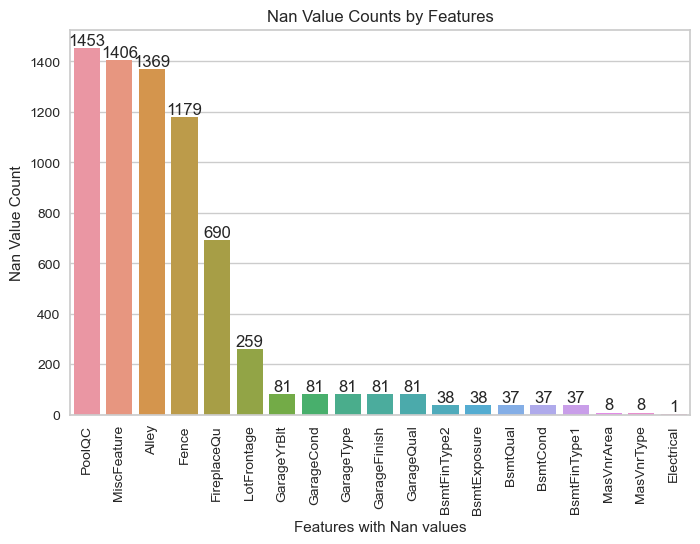

In [133]:
missing_handler.show_missing_values()

As we see above after checking the data description document, all of the missing values in train data actually not missing but meaning this feature is not exist in this property. Therefore i created and apply some replacements. But in the test data we observed some missing values and performed imputation with mode.

In [134]:
replacement_dictionary = {
                            'PoolQC'      : 'No Pool',
                            'MiscFeature' : 'No MiscFeatures',  
                            'Alley'       : 'No Alley Access',
                            'Fence'       : 'No Fence',
                            'FireplaceQu' : 'No FirePlace', 
                            'GarageFinish': 'No Garage',
                            'GarageQual'  : 'No Garage',
                            'GarageCond'  : 'No Garage',
                            'GarageType'  : 'No Garage',
                            'BsmtExposure': 'No Basement',
                            'BsmtCond'    : 'No Basement',
                            'BsmtQual'    : 'No Basement',
                            'BsmtFinType2': 'No Basement',
                            'BsmtFinType1': 'No Basement',
                            'Electrical'  : 'No Electrical',
                            'MasVnrType'  : 'No MasVnr',
                            'MasVnrArea'  : 0,
                            'LotFrontage' : 0,
                            'GarageYrBlt' : 0}

In [135]:
missing_handler.replace(replacement_dictionary)

In [136]:
missing_handler.show_missing_values()

There are no missing values


In [137]:
df2 = df1.copy()
print(df1.shape, ' ---> ', df2.shape)

(1460, 81)  --->  (1460, 81)


**Test Data**

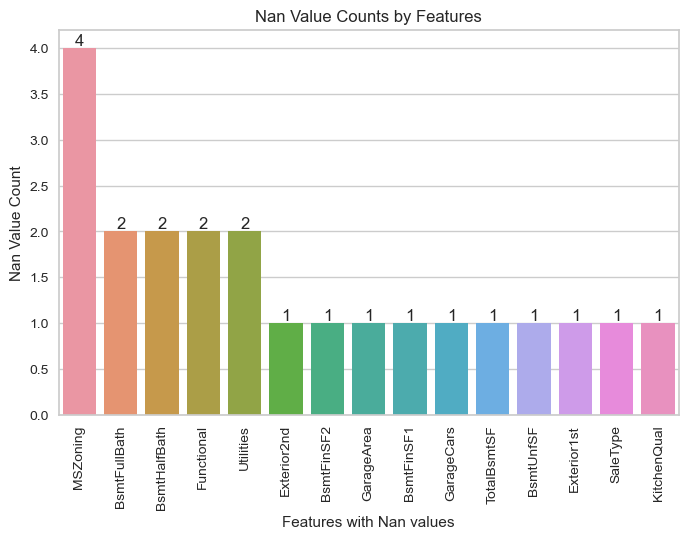

In [138]:
# For Test Data
missing_handler_test = Dealing_missing_values(df_test)
missing_handler_test.replace(replacement_dictionary)
missing_handler_test.show_missing_values()

In [139]:
# For Test Data
missing_handler_test = Dealing_missing_values(df_test)
missing_handler_test.replace(replacement_dictionary)
missing_handler_test.mmm(['MSZoning', 'Functional', 'Utilities', 'Exterior2nd', 'Exterior1st', 'SaleType', 'KitchenQual'], 'mode')

replacement_dictionary_test = {'BsmtFullBath':0, 'BsmtHalfBath':0, 'BsmtFinSF2':0, 'GarageArea':0, 'BsmtFinSF1':0, 'GarageCars':0, 'TotalBsmtSF':0, 'BsmtUnfSF':0}
missing_handler_test.replace(replacement_dictionary_test)
missing_handler_test.show_missing_values()

There are no missing values


In [140]:
df_test_2 = df_test.copy()
print(df_test.shape, ' ---> ', df_test_2.shape)

(1459, 80)  --->  (1459, 80)


## Feature Engineering

### Summarizing Features: Creating new Features and drop old ones

I have transformed, summarized or changed many columns here. But i think there are still **room for improvement in Age and Renovation Age,** with a keen eye on residuals models are not performing well with this two columns. It needs further investigation. Also, **TotalRmsAbvGr and BedroomAbvGr** can be used interchangebly to check for any effect. Because the effect of Bedrooms on the salePrice is not the same as Total Rooms. A bar plot will help for this purposes, but for a better correlation and better explanation i have selected Total Rooms feature 

In [141]:
# Hold 'GrLivArea' / drop '1stFlrSF', '2ndFlrSF'

# Hold 'TotRmsAbvGrd' / drop 'BedroomAbvGr'

# Create Total Bathrooms / drop 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'
df2['Total_Bathrooms'] = df2['BsmtFullBath'] + df2['FullBath'] + 0.5*(df2['BsmtHalfBath'] + df2['HalfBath'])

# Create Age of the House / drop 'YearBuilt'
df2['Age_of_Property'] = df2['YearBuilt'].max() - df2['YearBuilt']

# Create 'Age_of_Renovation' / drop 'YearRemodAdd'
df2['Age_of_Renovation'] = df2['YearBuilt'].max() - df2['YearRemodAdd']

# Hold 'GarageArea', create 'Has_Garage' binary / drop 'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond'
df2['HasGarage'] = (df2['GarageType'] != 'No Garage').astype(int)

I want to create a new feature with **median prices for each neighborhood** and drop neighborhoods itself. Because generally, prices are tightly dependent on the neighborhood. We can also work with sqft prices as well. I have used pivots and **aggregation** methods here.

In [142]:
# Create 'Neibhborhood_MedianP' / drop 'Neighborhood'
neighborhood_median_price = df2.groupby('Neighborhood')['SalePrice'].median().reset_index()
neighborhood_median_price.columns = ['Neighborhood', 'MedianHousePrice']
df2 = pd.merge(df2, neighborhood_median_price, on='Neighborhood', how='left')

**There are a ton of basement features, but they really effect the prices. If you dont believe, check the correlation table with SalePrices below in EDA part. Therefore i spent some time on Basement Features. Here is my process:**   
- I will give grades to Basement Quality, Basement Condition, Basement Exposure
- I will combine Basement FinTypes and Sq Footage into one feature having a grade
- Then i will combine all 4 features into one feature **Ovarall Basement Quality** with a total grade
- if the grade is zero - that means no basement/ but we need to check all the columns have synchronized no basement values or not
- i will drop the remaining

**To reach this Overall Basement Quality, i dont want to miss any information, so I am thinking to make a combined Basement Finishing Type Feature.**  
- Firstly, we will map the string categories into grades in BsmtFinType1 and BsmtFinType2
- Secondly, We will normalize BsmtFinSF1, BsmtFinSF2, BsmtUnfSF because all totally makes TotalBsmtSF
- Thirdly, SF1 * TYPE1_GRADE + SF2 * TYPE2_GRADE + SF3 * 1 (1 is the grade score of unf category)
- Actually BsmtUnfSF column is a seperated value from other columns because the other two columns have unf categories as well
- For example, if BsmtFinType2 == Unf normally we are expecting BsmtFinSF2 have a float value. But in our dataset it comes 0.0 and the value is coming with a seperate column named BsmtUnfSF. So we assume that they are iconic 

**Finally i will have two features related to Basement:**  
- BsmtOverallGrade
- TotalBsmtSF

In [143]:
# Define different mappings for each basement features (because we will make math operations/grading)
bsmt_qual_mapping = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'No Basement': 0}
bsmt_cond_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Basement': 0}
bsmt_exposure_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'No Basement': 0}
bsmt_fintype_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'No Basement': 0}

# Convert the categorical str values into grade points by mapping function
df2['BsmtFinType1'] = df2['BsmtFinType1'].map(bsmt_fintype_mapping)
df2['BsmtFinType2'] = df2['BsmtFinType2'].map(bsmt_fintype_mapping)
df2['BsmtQual'] = df2['BsmtQual'].map(bsmt_qual_mapping)
df2['BsmtCond'] = df2['BsmtCond'].map(bsmt_cond_mapping)
df2['BsmtExposure'] = df2['BsmtExposure'].map(bsmt_exposure_mapping)

# FinType has a numeric grade and a corresponding sqfoot, combine them
df2['BsmtFinGrade'] = (df2['BsmtFinType1'] * df2.BsmtFinSF1 / df2.TotalBsmtSF) + \
                      (df2['BsmtFinType2'] * df2.BsmtFinSF2 / df2.TotalBsmtSF) + \
                      (df2['BsmtFinType1'] * df2.BsmtUnfSF / df2.TotalBsmtSF)

# Because of zero division there will be Nan values where there are no basement, since TotalBsmtSf == 0
df2['BsmtFinGrade'].fillna(0.0, inplace=True)

# Combine into one single 'BsmtOverallGrade'
df2['BsmtOverallGrade'] = round((df2['BsmtQual'] + df2['BsmtCond'] + df2['BsmtExposure'] + df2['BsmtFinGrade']), 2)

# Drop :
# 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 
# 'BsmtFinSF2','BsmtUnfSF','BsmtFinGrade'

A similar approah of basement, i approach to Deck or Porch features. Here i used some domain knowledge by the help of my real estate expertise and arrange **weighs** list for each feature, then i simply combined all similar features into one **single new feature**

In [144]:
# Create 'Terrace_Grade' / drop 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
terrace_columns = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
terrace_weights = [1, 1, 2, 2, 2]

df2['Terrace_Grade'] = np.dot(df2[terrace_columns], terrace_weights)

__Dropping the columns__

In [145]:
col_drop_feat_eng = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr',
                     'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                    'YearBuilt', 'YearRemodAdd', 
                    'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond',
                    'Neighborhood', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 
                    'BsmtFinSF2','BsmtUnfSF','BsmtFinGrade',
                    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

In [146]:
df3 = df2.drop(columns=col_drop_feat_eng)
df3.shape

(1460, 59)

**Test Data**

we are just applying the same process to test data

In [147]:
# Create Total Bathrooms / drop 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'
df_test_2['Total_Bathrooms'] = df_test_2['BsmtFullBath'] + df_test_2['FullBath'] + 0.5*(df_test_2['BsmtHalfBath'] + df_test_2['HalfBath'])

# Create Age of the House / drop 'YearBuilt'
df_test_2['Age_of_Property'] = df_test_2['YearBuilt'].max() - df_test_2['YearBuilt']

# Create 'Age_of_Renovation' / drop 'YearRemodAdd'
df_test_2['Age_of_Renovation'] = df_test_2['YearBuilt'].max() - df_test_2['YearRemodAdd']

# Hold 'GarageArea', create 'Has_Garage' binary / drop 'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond'
df_test_2['HasGarage'] = (df_test_2['GarageType'] != 'No Garage').astype(int)

In [148]:
# Create 'Neibhborhood_MedianP' / drop 'Neighborhood'
df_test_2 = pd.merge(df_test_2, neighborhood_median_price, on='Neighborhood', how='left')

In [149]:
# Convert the categorical str values into grade points by mapping function
df_test_2['BsmtFinType1'] = df_test_2['BsmtFinType1'].map(bsmt_fintype_mapping)
df_test_2['BsmtFinType2'] = df_test_2['BsmtFinType2'].map(bsmt_fintype_mapping)
df_test_2['BsmtQual'] = df_test_2['BsmtQual'].map(bsmt_qual_mapping)
df_test_2['BsmtCond'] = df_test_2['BsmtCond'].map(bsmt_cond_mapping)
df_test_2['BsmtExposure'] = df_test_2['BsmtExposure'].map(bsmt_exposure_mapping)

# FinType has a numeric grade and a corresponding sqfoot, combine them
df_test_2['BsmtFinGrade'] = (df_test_2['BsmtFinType1'] * df_test_2.BsmtFinSF1 / df_test_2.TotalBsmtSF) + \
                      (df_test_2['BsmtFinType2'] * df_test_2.BsmtFinSF2 / df_test_2.TotalBsmtSF) + \
                      (df_test_2['BsmtFinType1'] * df_test_2.BsmtUnfSF / df_test_2.TotalBsmtSF)

# Because of zero division there will be Nan values where there are no basement, since TotalBsmtSf == 0
df_test_2['BsmtFinGrade'].fillna(0.0, inplace=True)

# Combine into one single 'BsmtOverallGrade'
df_test_2['BsmtOverallGrade'] = round((df_test_2['BsmtQual'] + df_test_2['BsmtCond'] + df_test_2['BsmtExposure'] + df_test_2['BsmtFinGrade']), 2)

In [150]:
# Create 'Terrace_Grade' / drop 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
df_test_2['Terrace_Grade'] = np.dot(df_test_2[terrace_columns], terrace_weights)

In [151]:
df_test_3 = df_test_2.drop(columns=col_drop_feat_eng)
print(df_test_2.shape, ' ---> ', df_test_3.shape)

(1459, 88)  --->  (1459, 58)


### High and Low Cardinality

**High Cardinality:** High cardinality features (features with a large number of unique values) can sometimes introduce noise into the model.  
**Low Cardinality:** Low cardinality features with little variation may not contribute much information.

Cardinality is an issue for categorical variables. But our dataset has some categorical features as coded like numeric as well 

In [152]:
# I have some ready methods to draw histograms and barplots of all features, a good way to quickly SCANNING of distributions
from data.fatih_eda import plot_histograms_for_all_numeric, plot_barplot_all_categoric

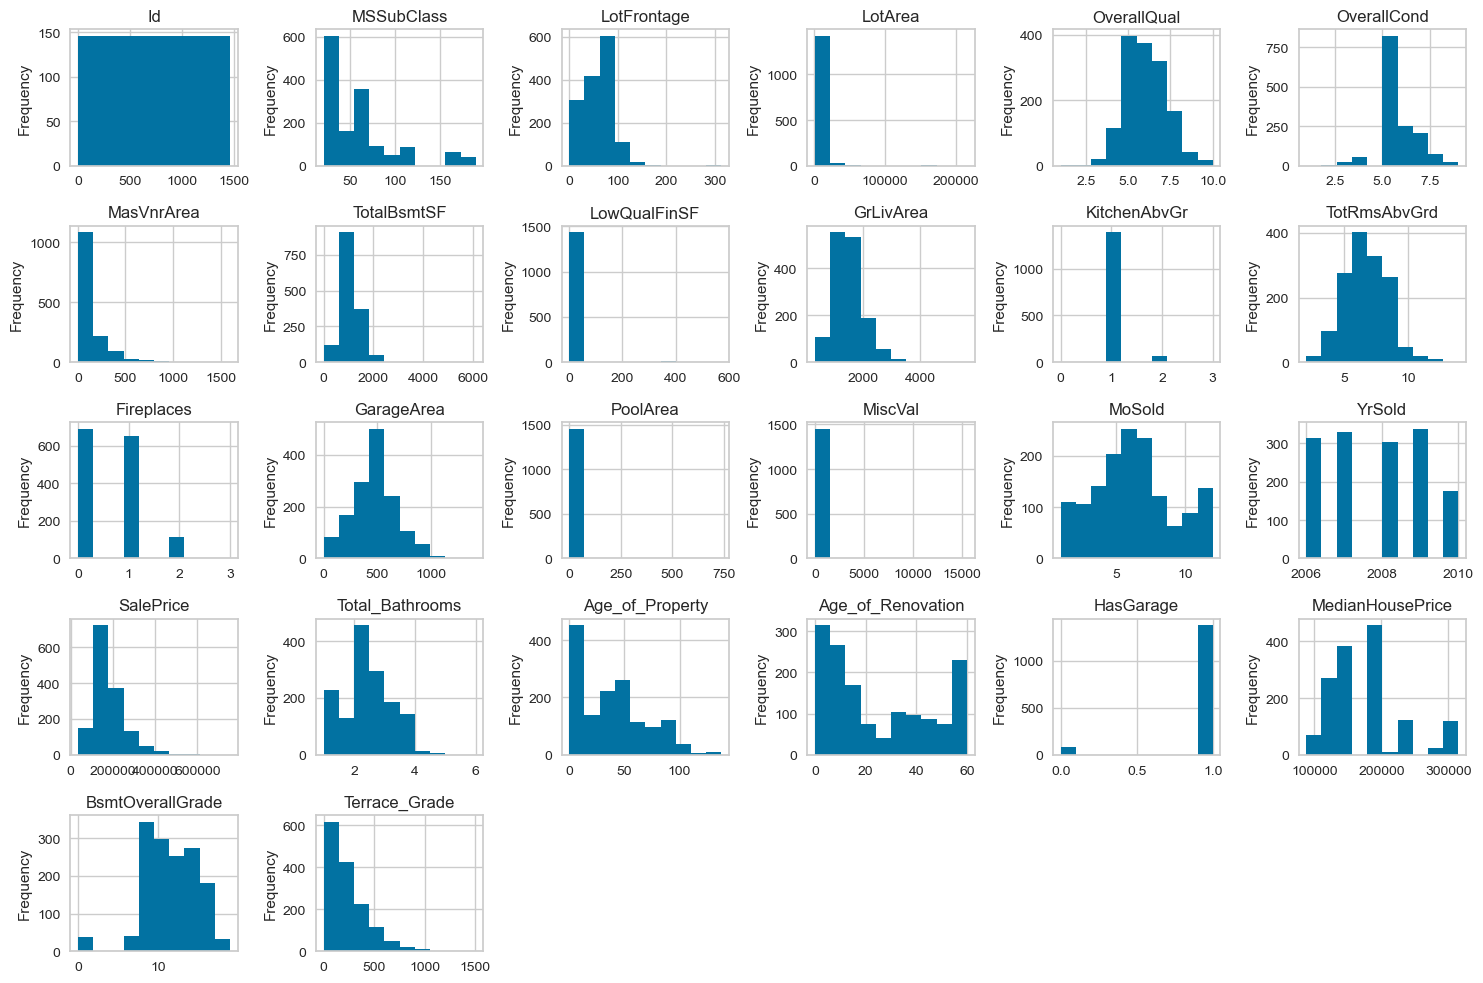

In [153]:
plot_histograms_for_all_numeric(df3)

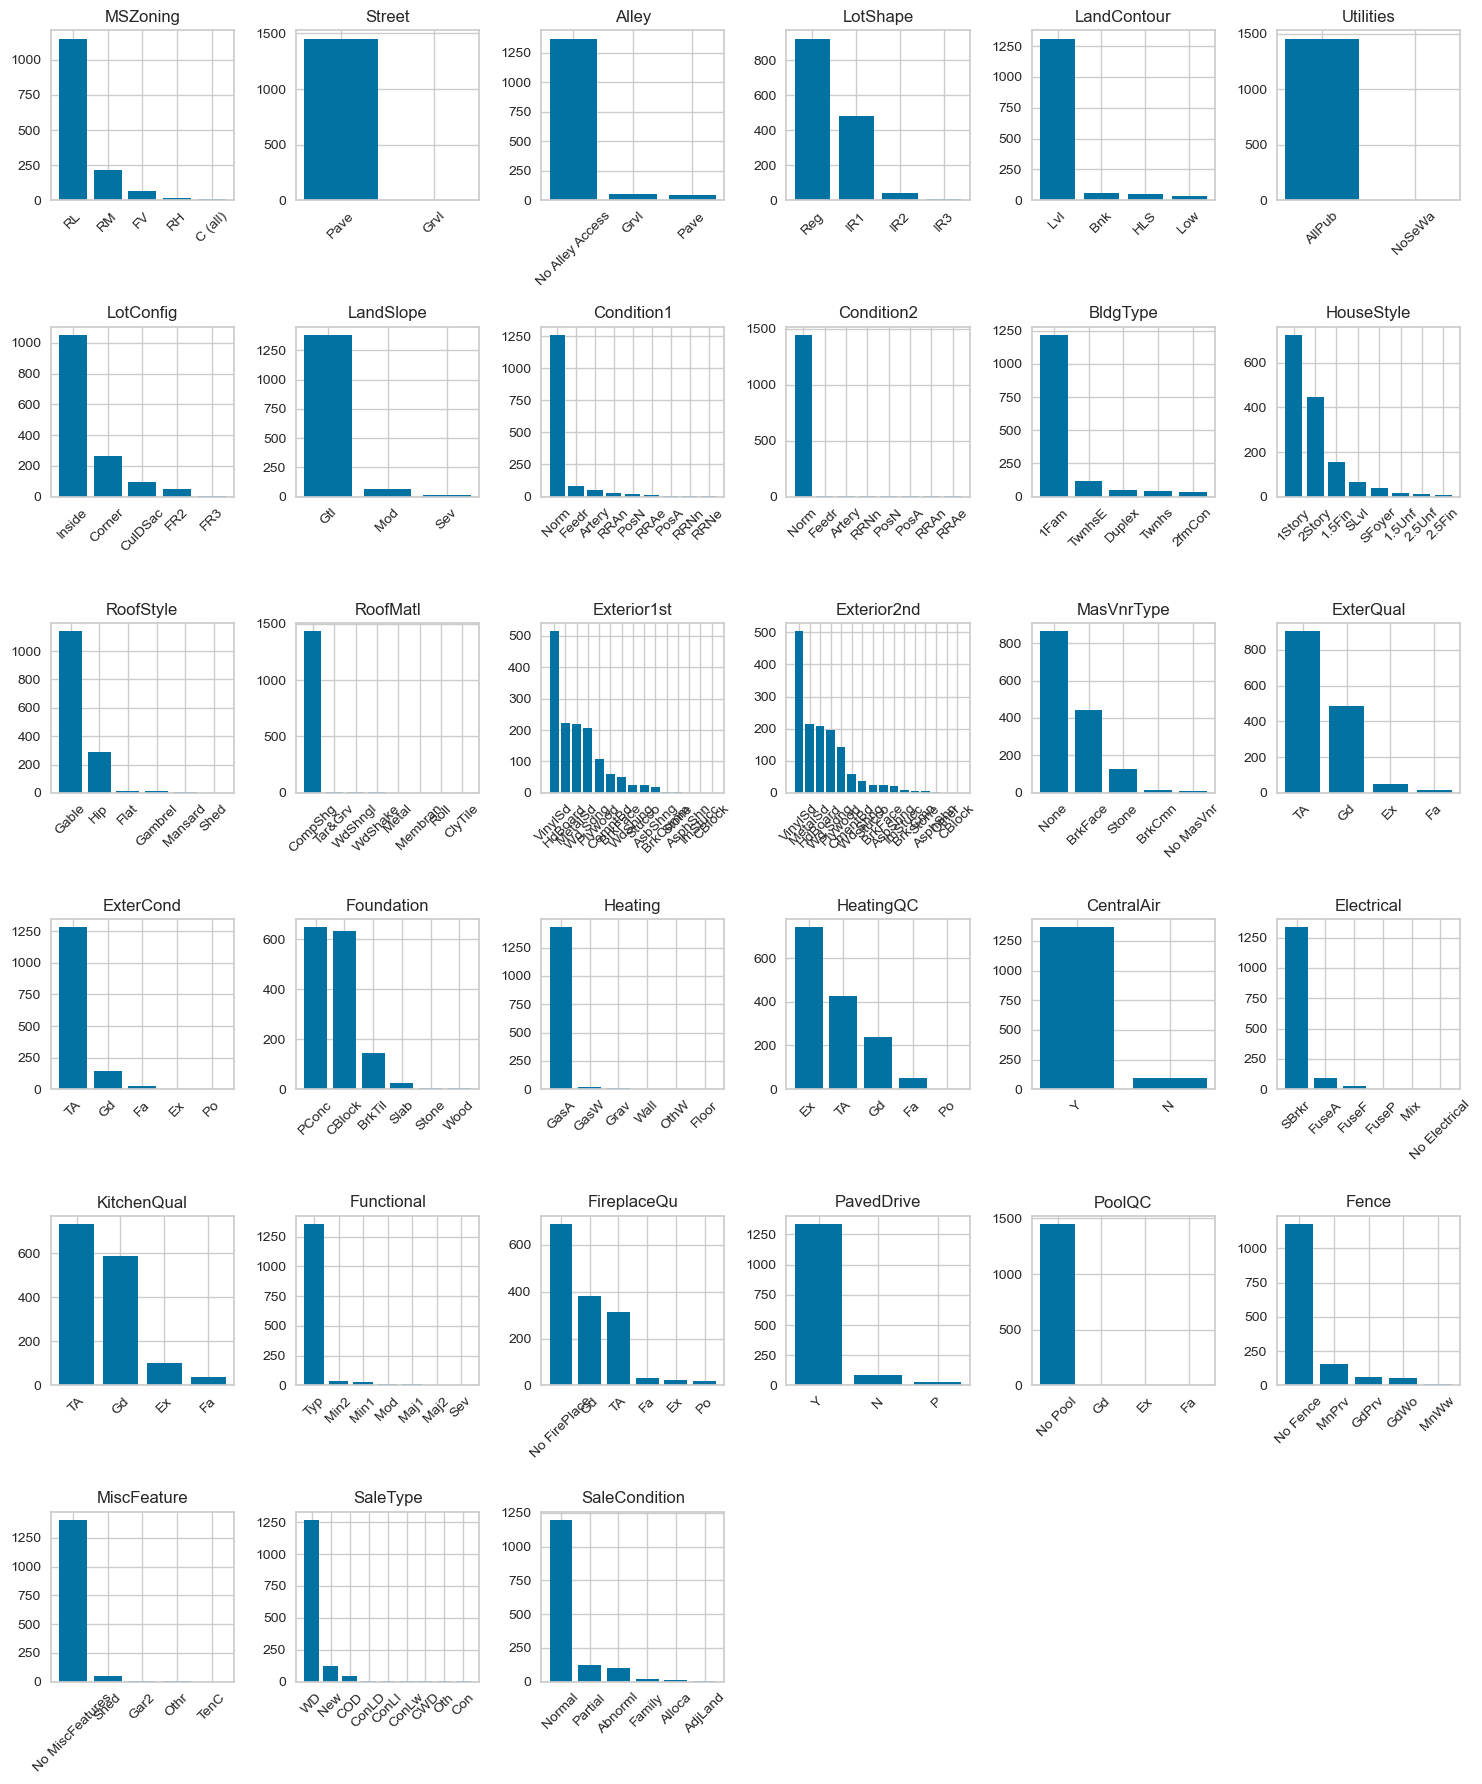

In [154]:
plot_barplot_all_categoric(df3)

In [155]:
# From scanning the visualizations, i wanted to stack the variables for checking them below
cat_feat_check_cardinality = ['Id', 'KitchenAbvGr', 'HasGarage', 'Street', 'Alley', 'Utilities', 
                              'Condition1', 'Condition2', 'RoofMatl', 'ExterCond', 'Heating', 'CentralAir', 
                              'Electrical', 'Functional', 'PavedDrive', 'PoolQC', 'MiscFeature', 'SaleType', 'SaleCondition'  ]
cont_feat_check_cardinalty = ['LowQualFinSF', 'PoolArea', 'MiscVal' ]

In [156]:
# I can Check the correlations of suspicious low-varied features with Target, if their effect is very low on target better to let them go
cardinality_drop_columns = []
for col in cont_feat_check_cardinalty:
    coref = df3[col].corr(df3['SalePrice'])
    if abs(coref) < 0.1:
        cardinality_drop_columns.append(col)
        print(f"Correlation of {col} with Sale Price is {coref}")

Correlation of LowQualFinSF with Sale Price is -0.025606130000679548
Correlation of PoolArea with Sale Price is 0.09240354949187314
Correlation of MiscVal with Sale Price is -0.021189579640303245


In [157]:
# I can check value_counts % of categorical and so called categorical variables
# I created a treshhold here (%3 and %97). If the observations are stacked in a single value within treshold limit, let them go 

for col in cat_feat_check_cardinality:
    vc_df = df3[col].value_counts(normalize=True).sort_values(ascending=False).reset_index()
    freq = round(vc_df.iloc[0,1], 3)
    value = vc_df.iloc[0,0]
    if (freq > 0.97) or (freq < 0.03):
        cardinality_drop_columns.append(col)
        print(f"{col.ljust(15)} -- {str(value).ljust(15)} -- {freq}")

Id              -- 1               -- 0.001
Street          -- Pave            -- 0.996
Utilities       -- AllPub          -- 0.999
Condition2      -- Norm            -- 0.99
RoofMatl        -- CompShg         -- 0.982
Heating         -- GasA            -- 0.978
PoolQC          -- No Pool         -- 0.995


In [158]:
cardinality_drop_columns

['LowQualFinSF',
 'PoolArea',
 'MiscVal',
 'Id',
 'Street',
 'Utilities',
 'Condition2',
 'RoofMatl',
 'Heating',
 'PoolQC']

In [159]:
df4 = df3.drop(columns=cardinality_drop_columns)

In [160]:
print(df3.shape, '--->', df4.shape)

(1460, 59) ---> (1460, 49)


__Test Data__

In [161]:
df_test_4 = df_test_3.drop(columns=cardinality_drop_columns)
print(df_test_3.shape, ' ---> ', df_test_4.shape)

(1459, 58)  --->  (1459, 48)


## Outliers

### Approach-1

__In the first iteration, i will not drop any outliers__

__But lets observe them__

In [162]:
# I have class in my library to deal with outliers, lets import and instantiate an object
from data.fatih_eda import FatihOutliers

In [163]:
outliers = FatihOutliers(df4)

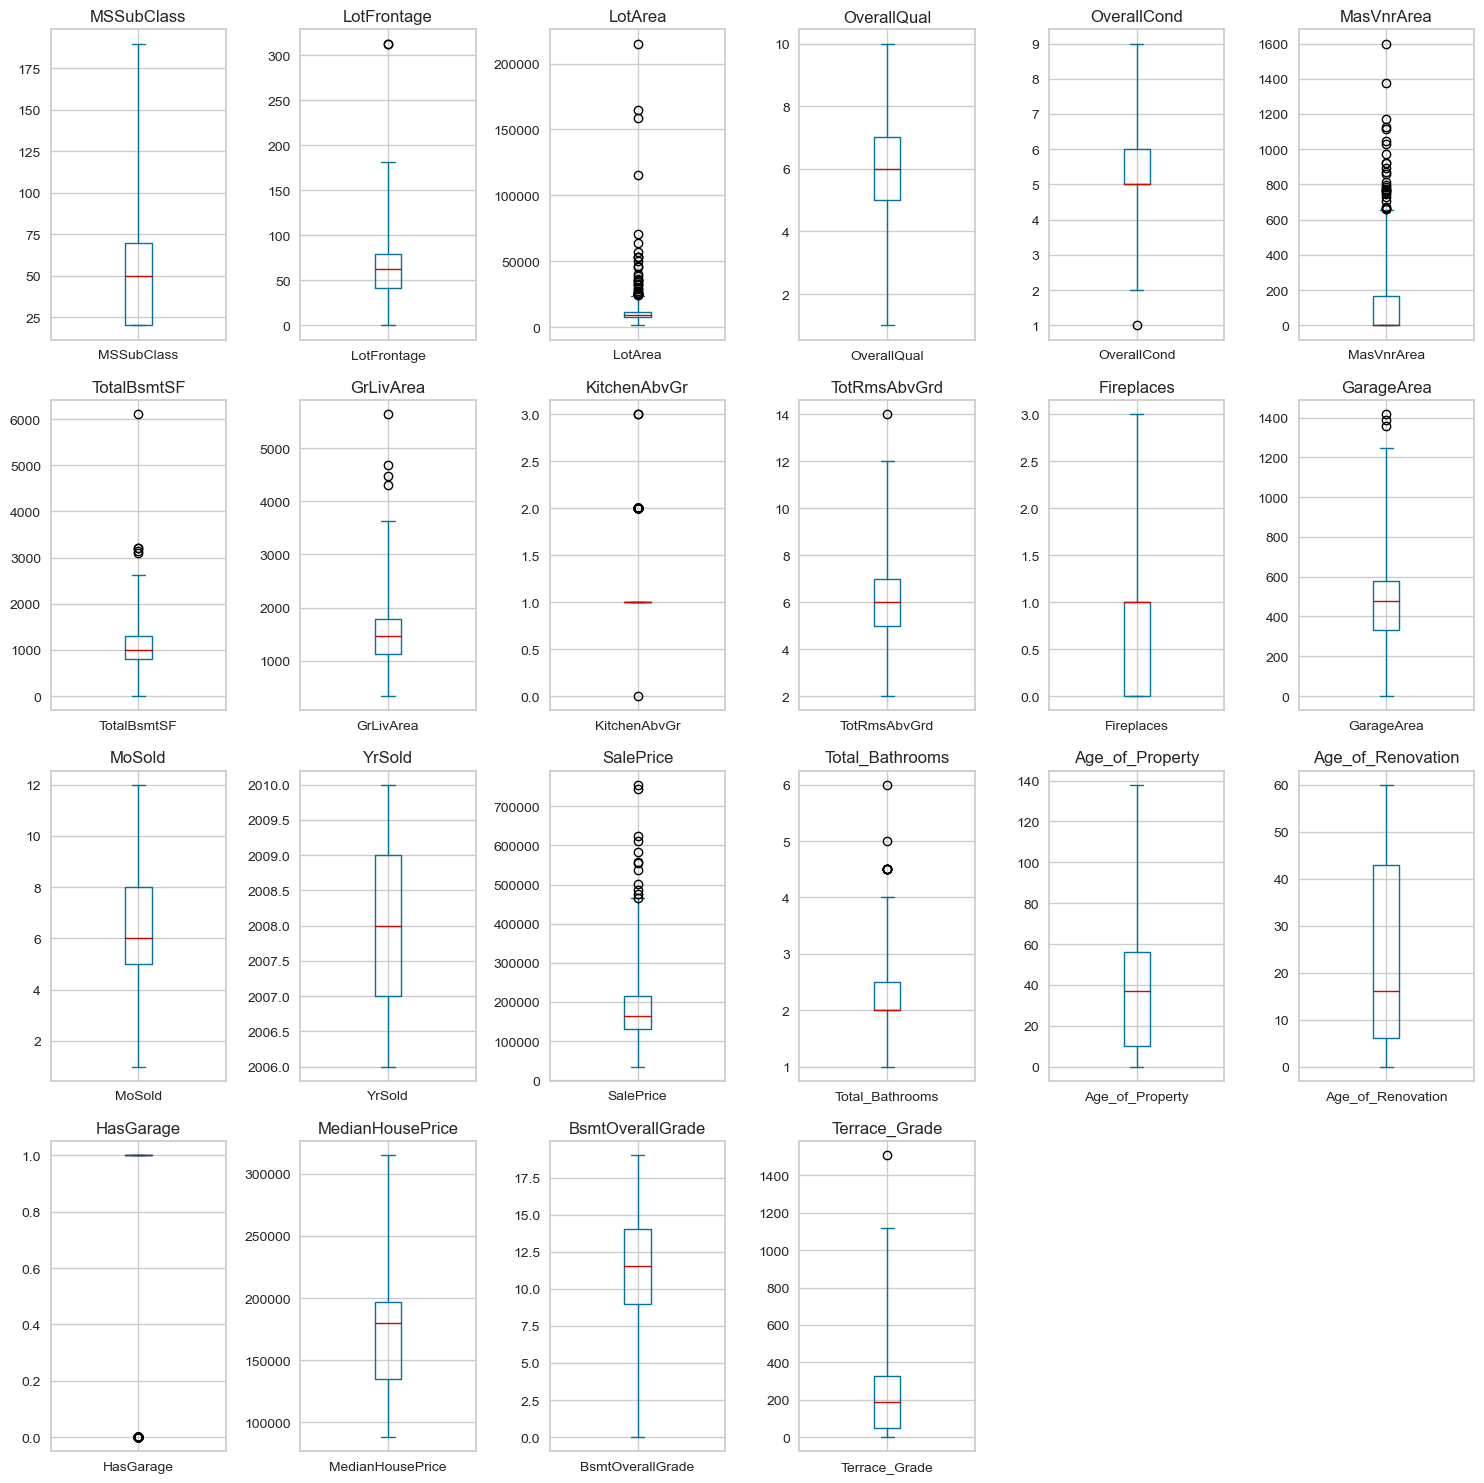

In [164]:
outliers.plot_boxplots_for_all_numeric(IQR_multi=3)

In [165]:
# if you choose approach-1, activate this cell

# df5 = df4.copy()

### Approach-2

Actually 249 is not the real number, Garage, Kitchen, MasVnrAre can be skipped due to their nature, but the rest are important outliers.  
Here is my **approach:**  
- Firstly i will be hesitant to remove much outliers
- Try to see the results, inspect residuals and etc
- Then will be more flexible do drop 
- Again inspect the results and compare which one is better

__Manually Outlier Check__

In [166]:
o1 = outliers.show_outliers_for_features('LotFrontage')
o1

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
934,20,RL,313.0,27650,No Alley Access,IR2,HLS,Inside,Mod,PosA,1Fam,1Story,7,7,Flat,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,585,Ex,Y,SBrkr,2069,1,Gd,9,Typ,1,Gd,505,Y,No Fence,No MiscFeatures,11,2008,WD,Normal,242000,3.0,50,3,1,140000.0,17.0,0
1298,60,RL,313.0,63887,No Alley Access,IR3,Bnk,Corner,Gtl,Feedr,1Fam,2Story,10,5,Hip,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,6110,Ex,Y,SBrkr,5642,1,Ex,12,Typ,3,Gd,1418,Y,No Fence,No MiscFeatures,1,2008,New,Partial,160000,4.5,2,2,1,121750.0,18.0,506


In [167]:
o2 = outliers.show_outliers_for_features('MasVnrArea').sort_values(by='MasVnrArea', ascending=False).head(2)
o2

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
297,60,FV,66.0,7399,Pave,IR1,Lvl,Inside,Gtl,Norm,1Fam,2Story,7,5,Hip,VinylSd,VinylSd,BrkFace,1600.0,Gd,TA,PConc,975,Ex,Y,SBrkr,1950,1,Gd,7,Typ,1,TA,576,Y,No Fence,No MiscFeatures,6,2007,WD,Normal,239000,2.5,13,12,1,225500.0,12.0,406
1169,60,RL,118.0,35760,No Alley Access,IR1,Lvl,CulDSac,Gtl,Norm,1Fam,2Story,10,5,Hip,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,1930,Ex,Y,SBrkr,3627,1,Gd,10,Typ,1,TA,807,Y,No Fence,No MiscFeatures,7,2006,WD,Normal,625000,4.5,15,14,1,301500.0,18.0,437


In [168]:
o3 = outliers.show_outliers_for_features('TotalBsmtSF').sort_values(by='TotalBsmtSF', ascending=False).head(1)
o3

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
1298,60,RL,313.0,63887,No Alley Access,IR3,Bnk,Corner,Gtl,Feedr,1Fam,2Story,10,5,Hip,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,6110,Ex,Y,SBrkr,5642,1,Ex,12,Typ,3,Gd,1418,Y,No Fence,No MiscFeatures,1,2008,New,Partial,160000,4.5,2,2,1,121750.0,18.0,506


In [169]:
o4 = outliers.show_outliers_for_features('GrLivArea')
o4

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
523,60,RL,130.0,40094,No Alley Access,IR1,Bnk,Inside,Gtl,PosN,1Fam,2Story,10,5,Hip,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,3138,Ex,Y,SBrkr,4676,1,Ex,11,Typ,1,Gd,884,Y,No Fence,No MiscFeatures,10,2007,New,Partial,184750,4.5,3,2,1,121750.0,18.0,614
691,60,RL,104.0,21535,No Alley Access,IR1,Lvl,Corner,Gtl,Norm,1Fam,2Story,10,6,Gable,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,2444,Ex,Y,SBrkr,4316,1,Ex,10,Typ,2,Ex,832,Y,No Fence,No MiscFeatures,1,2007,WD,Normal,755000,4.0,16,15,1,301500.0,18.0,432
1182,60,RL,160.0,15623,No Alley Access,IR1,Lvl,Corner,Gtl,Norm,1Fam,2Story,10,5,Hip,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,2396,Ex,Y,SBrkr,4476,1,Ex,10,Typ,2,TA,813,Y,MnPrv,No MiscFeatures,7,2007,WD,Abnorml,745000,4.5,14,14,1,301500.0,17.0,249
1298,60,RL,313.0,63887,No Alley Access,IR3,Bnk,Corner,Gtl,Feedr,1Fam,2Story,10,5,Hip,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,6110,Ex,Y,SBrkr,5642,1,Ex,12,Typ,3,Gd,1418,Y,No Fence,No MiscFeatures,1,2008,New,Partial,160000,4.5,2,2,1,121750.0,18.0,506


In [170]:
o5 = outliers.show_outliers_for_features('TotRmsAbvGrd')
o5

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
635,190,RH,60.0,10896,Pave,Reg,Bnk,Inside,Gtl,Feedr,2fmCon,2.5Fin,6,7,Hip,VinylSd,VinylSd,None,0.0,Fa,TA,CBlock,1440,Ex,Y,FuseA,3395,2,Fa,14,Typ,0,No FirePlace,0,N,No Fence,No MiscFeatures,3,2007,WD,Abnorml,200000,2.0,96,15,0,139500.0,8.0,110


In [171]:
o6 = outliers.show_outliers_for_features('Terrace_Grade')
o6

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
1328,50,RM,60.0,10440,Grvl,Reg,Lvl,Corner,Gtl,Norm,1Fam,1.5Fin,6,7,Gable,BrkFace,Wd Sdng,None,0.0,Gd,Gd,BrkTil,1510,Ex,Y,SBrkr,2792,1,TA,8,Mod,2,TA,520,Y,MnPrv,Shed,6,2008,WD,Normal,256000,2.0,90,60,1,119000.0,10.0,1507


In [172]:
outliers_index_drop = list(set(list(o1.index) + list(o2.index) + list(o3.index) + list(o4.index) + list(o5.index) + list(o6.index)))
outliers_index_drop

[934, 297, 523, 1328, 1169, 1298, 691, 635, 1182]

In [173]:
# if you choose approach 2, activate this cell

# df5 = df4.drop(index=outliers_index_drop)

### Approach-3

**This is an iteration after first model run**  
This time i will be a bit more flexible to remove more outliers. I will focus on IQR 4

In [174]:
# I need to instantiate my handler again, since the dataframe changed
outliers = FatihOutliers(df4)

In [175]:
# if you choose approach-3, activate this cell

outlier_columns_a3 = ['LotArea', 'SalePrice', 'TotalBsmtSF', 'KitchenAbvGr']
indexes = []
for col in outlier_columns_a3:
    indexes += list(outliers.show_outliers_for_features(col=col, IQR_multi=4).index)
indexes = list(set(indexes))

df5 = df4.drop(index=indexes)

In [176]:
print(df4.shape, ' ---> ', df5.shape)

(1460, 49)  --->  (1363, 49)


In [177]:
outliers = FatihOutliers(df5)

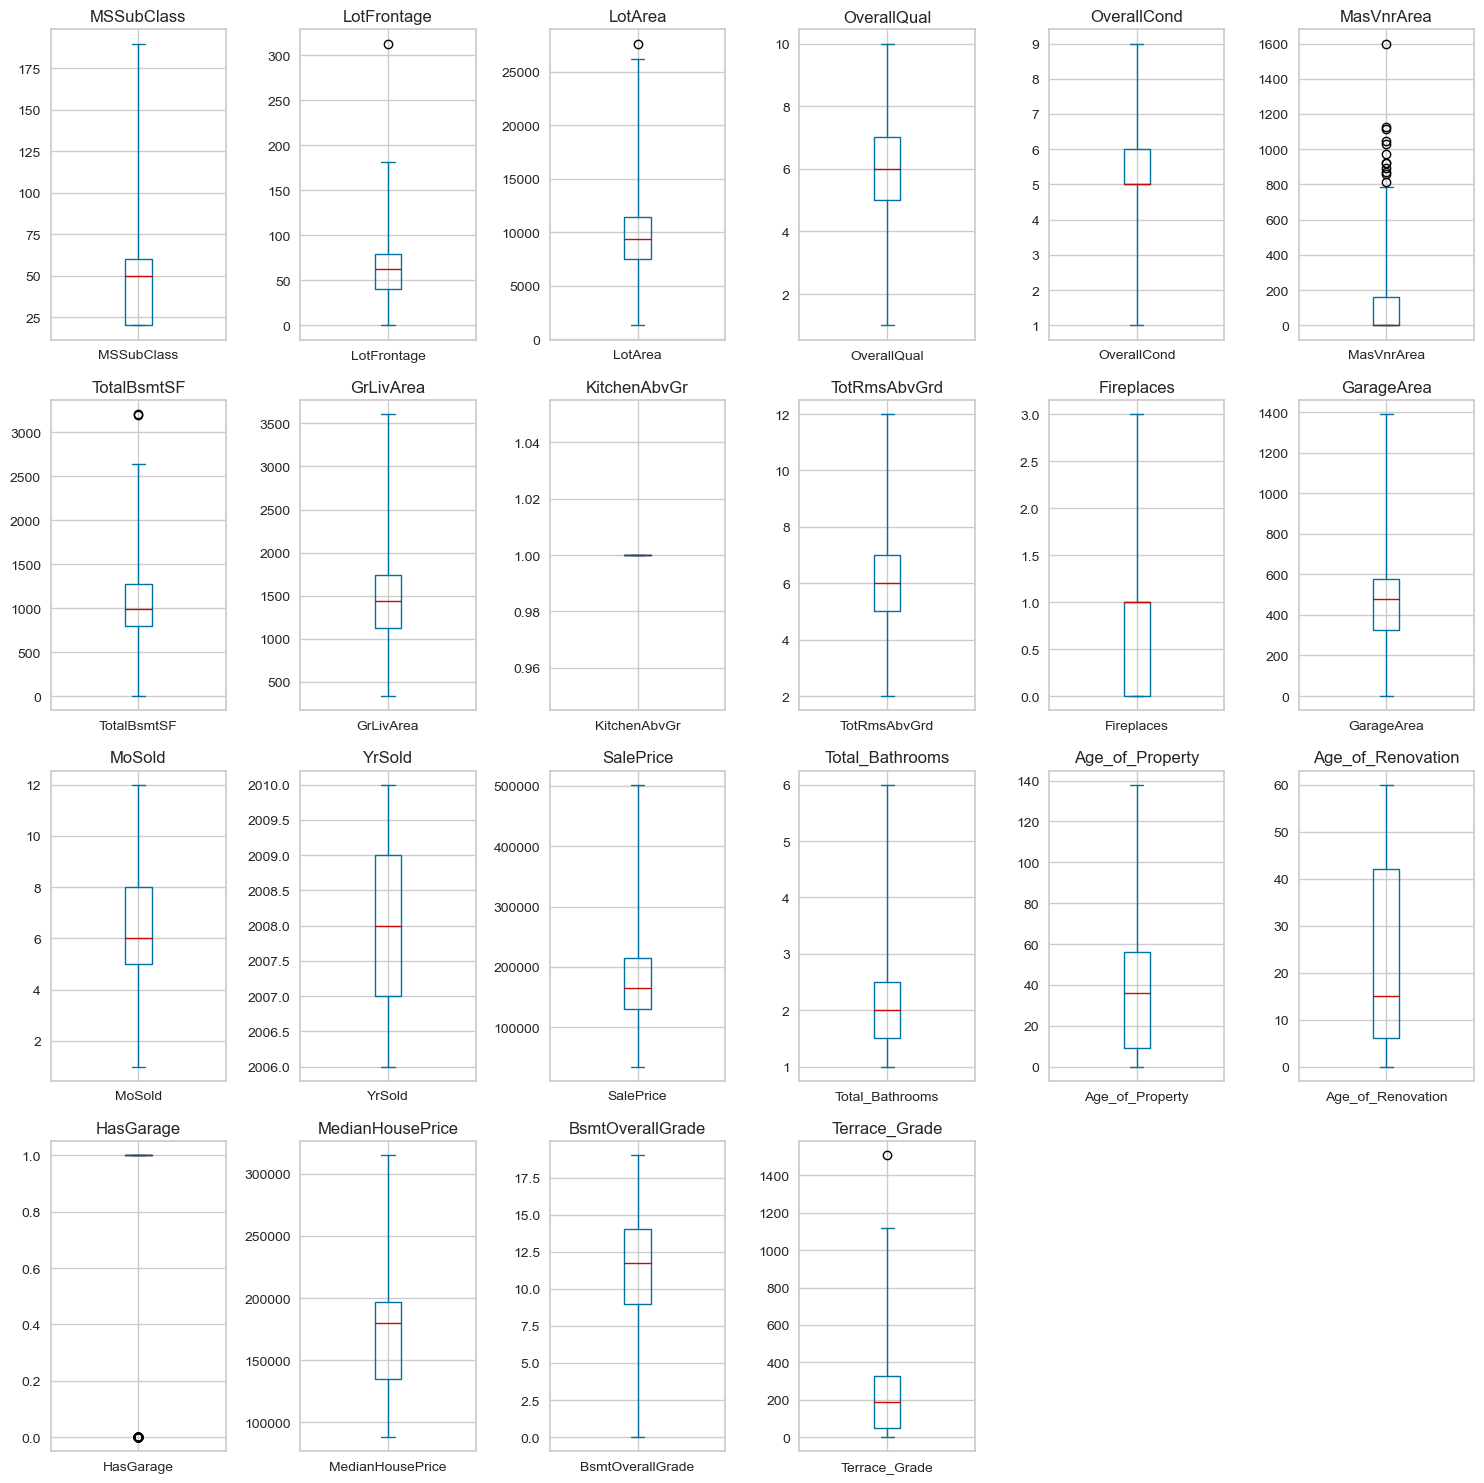

In [178]:
outliers.plot_boxplots_for_all_numeric(IQR_multi=4)

# 2. Exploratory Data Analysis

## Exploring The Relationships with Target

### Numeric Variables

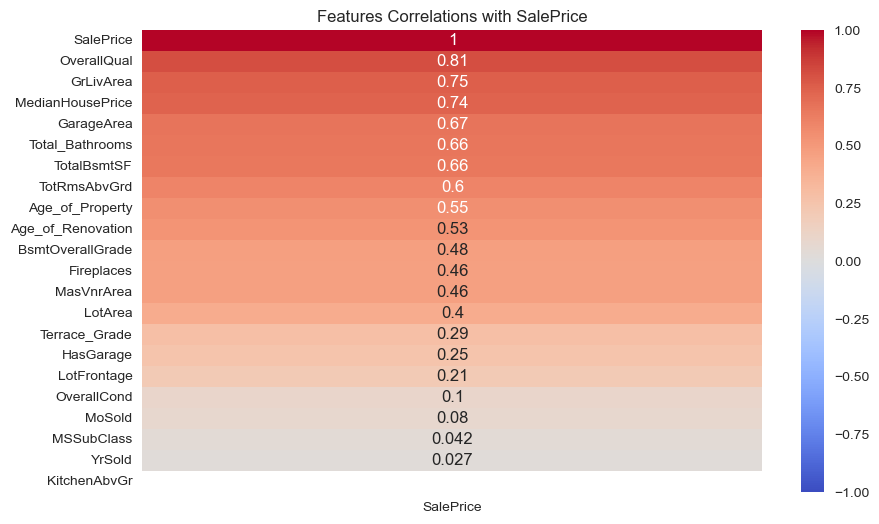

In [179]:
target_column = 'SalePrice'
corr_matrix = df5.corr()
corr_with_target = corr_matrix[target_column].apply(np.abs).sort_values(ascending=False)


plt.figure(figsize=(10, 6))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title(f'Features Correlations with {target_column}')
plt.show()

There is a clear picture here as expected **OverallQual, MedianhousePrice, GrLivAre** are effecting sale price a lot. And some features dont really effect the sale price. I consider to remove them from my dataset

**What happened to --OVERALLCOND-- I think there is a room to improve and engineer this feature since its correlation far low than expected, i think it needs some transformation.**

### Categorical Variables

Altough its not so common i want to check the correlations of categorical variables with the dependent variable, SalePrice. Firstly i will encode them temporarily to reach numeric values (it can be fine tuned with adding label encoding, but i just want to see general picture here), then combine each correlation into features 

In [180]:
categorical_columns = df5.select_dtypes(include='object').columns
categorical_columns

Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'PavedDrive', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [181]:
df_encoded_temporary = pd.get_dummies(df5[categorical_columns], drop_first=True)

In [182]:
df_encoded_temporary['SalePrice'] = df5['SalePrice']
target_column = 'SalePrice'
corr_matrix = df_encoded_temporary.corr()
corr_with_target = corr_matrix[target_column].apply(np.abs).sort_values(ascending=False)

corr_with_target.nlargest(5)

SalePrice           1.000000
ExterQual_TA        0.615896
KitchenQual_TA      0.543029
Foundation_PConc    0.520818
ExterQual_Gd        0.492461
Name: SalePrice, dtype: float64

In [183]:
# Combine all dummy variable correlations into features

corr_of_categoric_columns = {}
for col in categorical_columns:
    corr_of_categoric_columns[col] = []
    vc = df5[col].value_counts(normalize=True)
    
    #iterate through corr matrix index and values
    for i,v in corr_with_target.items():
        c_sc = i.split('_')
        if col == c_sc[0]:
            
            #find the weight of sub-categories depending on frequncy
            weight = vc[c_sc[1]]
            corr_for_sub_cateory = v * weight
            corr_of_categoric_columns[col].append(corr_for_sub_cateory)
            
corr_of_categoric_columns = {key: sum(value) for key, value in corr_of_categoric_columns.items()}
corr_of_categoric_columns_df = pd.DataFrame(list(corr_of_categoric_columns.items()), columns=['Categorical Feature', 'Correlation with SalePrice'])
corr_of_categoric_columns_df.sort_values(by='Correlation with SalePrice', ascending=False).head(10)

,Categorical Feature,Correlation with SalePrice
13,ExterQual,0.548329
19,KitchenQual,0.420909
15,Foundation,0.400558
21,FireplaceQu,0.350428
12,MasVnrType,0.330188
25,SaleType,0.262166
0,MSZoning,0.247591
17,CentralAir,0.238301
22,PavedDrive,0.233497
18,Electrical,0.233312


## MultiCollinearity

In [184]:
# Correlation Matrix of Numeric Variables
df5.drop(columns=['SalePrice']).corr()[
                                        (df5.drop(columns=['SalePrice']).corr() >=0.8) &
                                        (df5.drop(columns=['SalePrice']).corr() <1)
                                       ].style.background_gradient(axis=None)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,TotalBsmtSF,GrLivArea,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,MoSold,YrSold,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
MSSubClass,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
LotFrontage,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
LotArea,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
OverallQual,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
OverallCond,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
MasVnrArea,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
TotalBsmtSF,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
GrLivArea,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.836915,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
KitchenAbvGr,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
TotRmsAbvGrd,nan,nan,nan,nan,nan,nan,nan,0.836915,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


__i can check vif and cramers v as well, but i will not make it more complicated in this version, but i am holding df5 for multi coll check__

In [185]:
df6 = df5.copy()
print(df5.shape, ' ---> ', df6.shape)

(1363, 49)  --->  (1363, 49)


# 3. Data Transformations

## Log Transformation: Sale Price

In [186]:
small_constant = 0.0001   # this is to prevent infinity after log transformation
df6['SalePrice'] = np.log(df6['SalePrice'] + small_constant)

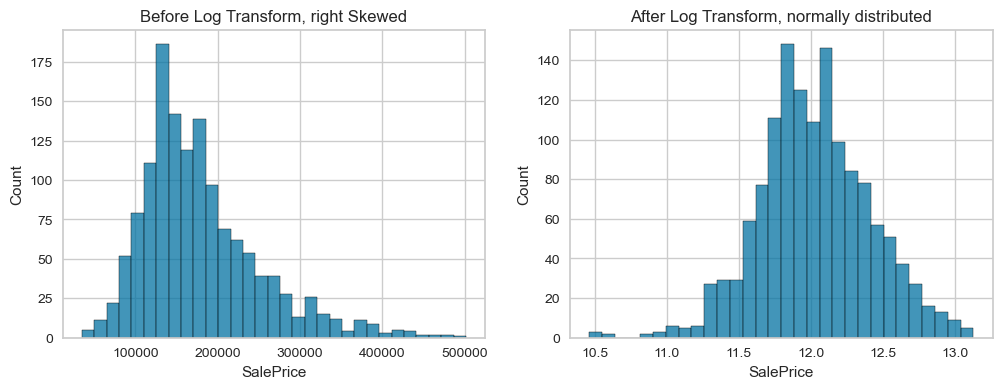

In [187]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes= axes.flatten()
sns.histplot(df5['SalePrice'], ax=axes[0])
sns.histplot(df6['SalePrice'], ax=axes[1])
axes[0].set_title('Before Log Transform, right Skewed')
axes[1].set_title('After Log Transform, normally distributed')
plt.show()

## Encoding

In [188]:
categorical_columns = df6.select_dtypes(include='object').columns

In [189]:
ordinal_mapping = {
    'Street': {'Grvl':1, 'Pave':2},
    'Alley' : {'Grvl':1, 'Pave':2, 'No Alley Access':0},
    'LotShape' : {'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4 },
    'LandContour' : {'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4 },
    'LandSlope' : {'Sev':1, 'Mod':2, 'Gtl':3},
    'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Basement': 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Basement': 0},
    'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No':1, 'No Basement': 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'No Basement': 0},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'No Basement': 0},    
    'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No FirePlace': 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Garage': 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Garage': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'No Garage': 0},
    'PavedDrive': {'Y': 3, 'P': 2, 'N': 1},
    'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'No Pool': 0},
    'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'No Fence': 0},        
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},
    'CentralAir': {'Y': 1, 'N': 0}
}

In [190]:
# Apply Ordinal Encoding
for var in categorical_columns:
    if var in ordinal_mapping.keys():
        df6[var] = df6[var].map(ordinal_mapping[var])

In [191]:
# Apply Nominal Encoding
nominal_categorical_vars = [col for col in categorical_columns if col not in ordinal_mapping.keys()]
df_encoded = pd.get_dummies(df6[nominal_categorical_vars], columns=nominal_categorical_vars)
df6 = pd.concat([df6, df_encoded], axis=1)
df10 = df6.drop(columns=nominal_categorical_vars)

In [192]:
df10.shape

(1363, 140)

**Test Data**

In [193]:
df_test_9 = df_test_4.copy()

In [194]:
# Apply Ordinal Encoding
for var in categorical_columns:
    if var in ordinal_mapping.keys():
        df_test_9[var] = df_test_9[var].map(ordinal_mapping[var])

In [195]:
# Apply Nominal Encoding
df_encoded = pd.get_dummies(df_test_9[nominal_categorical_vars], columns=nominal_categorical_vars)
df_test_9 = pd.concat([df_test_9, df_encoded], axis=1)
df_test_10 = df_test_9.drop(columns=nominal_categorical_vars)
df_test_10.drop
print(df_test_10.shape)

(1459, 133)


## Aligning Datas if Needed

In [196]:
is_columns_aligned(df10, df_test_10)

Train and test datasets have different columns.
Columns in train but not in test: {'SalePrice', 'MiscFeature_TenC', 'Exterior2nd_Other', 'Electrical_No Electrical', 'HouseStyle_2.5Fin', 'Exterior1st_Stone', 'Electrical_Mix', 'Exterior1st_ImStucc'}
Columns in test but not in train: {'Exterior1st_AsphShn'}


**4 columns have extra values in train data but not exist in test data**  
this will bring **8 extra columns** ---> I will combine these extra values with the nearest possible value

In [197]:
df10['HouseStyle_2Story']  = df10['HouseStyle_2.5Fin'] + df10['HouseStyle_2Story']
df10['Exterior1st_AsphShn'] = df10['Exterior1st_Stone'] + df10['Exterior1st_ImStucc'] + df10['Exterior1st_AsphShn']
df10['Electrical_FuseP'] = df10['Electrical_Mix'] + df10['Electrical_No Electrical'] + df10['Electrical_FuseP']
df10['MiscFeature_Othr']  = df10['MiscFeature_TenC'] + df10['MiscFeature_Othr']

df10.drop(columns=['HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Electrical_Mix', 'Electrical_No Electrical', 'MiscFeature_TenC'], inplace=True)
df10.drop(columns=['Exterior2nd_Other'], inplace=True)

KeyError: 'Exterior1st_AsphShn'

In [ ]:
is_columns_aligned(df10, df_test_10)

---------------------------------------------------

# Feature Engineering Iteration

In [ ]:
# Activate this cell for multi col drop

df10.drop(columns=['HasGarage', 'KitchenQual'], inplace=True)
df_test_10.drop(columns=['HasGarage', 'KitchenQual'], inplace=True)

## Feature & Target Dataset

In [ ]:
# Lets seperate X and y
X = df10.drop(columns = ['SalePrice'])
y = df10['SalePrice']

# this dataset is not for model train and validation but only making predictions to kaggle, 
# assume it like live and new coming data
X_real_test = df_test_10   

In [ ]:
print(f"X shape is: {X.shape}")
print(f"y shape is: {y.shape}")
print(f"X test for Kaggle Predictions shape is: {X_real_test.shape}")

# 4. Model Building

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")
print(f"X_test shape is: {X_test.shape}")
print(f"y_test shape is: {y_test.shape}")

## Standardizing

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
standard_scaler = StandardScaler()

In [ ]:
X_train_standardized = standard_scaler.fit_transform(X_train)
X_test_standardized = standard_scaler.transform(X_test)

## Creating a Baseline Model

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
baseline_prediction = y_train.mean()
baseline_mse = mean_squared_error(y_test, [baseline_prediction] * len(y_test))
baseline_rmse = baseline_mse**0.5
baseline_rmse

## Initial Model Run

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold

We will train following models with default parametres to compare scores:  
* linear regression  
* ridge regression  
* lasso regression  

In [ ]:
# Linear model without cross validation

linear_model = LinearRegression()
linear_model

In [ ]:
def train_val(y_train, y_train_pred, y_test, y_pred, i):
    scores = {i+"_train": {"R2" : r2_score(y_train, y_train_pred),
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    i+"_test": {"R2" : r2_score(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    return pd.DataFrame(scores)

In [ ]:
linear_model.fit(X_train_standardized, y_train)
y_pred = linear_model.predict(X_test_standardized)
y_train_pred = linear_model.predict(X_train_standardized)

linear_model_scores = train_val(y_train, y_train_pred, y_test, y_pred, 'linear')
linear_model_scores

In [ ]:
# Linear Model with cross Validation in pipeline
from sklearn.pipeline import Pipeline 

pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]
)
pipeline

In [ ]:
# Perform cross-validation with scaled data and multiple metrics
linear_cv_results = cross_validate(pipeline, X, y, cv=10, scoring=('r2', 'neg_mean_squared_error'))

# Extract and print the results
linear_cv_results = pd.DataFrame(linear_cv_results).iloc[:, 2:]
print(f"r2 Mean: {round(linear_cv_results['test_r2'].mean(), 2)}")
print(f"-RMSE Mean: {round(linear_cv_results['test_neg_mean_squared_error'].mean(), 4)}")
linear_cv_results

In [ ]:
# Alternative Cross Validation
def custom_cv_indices(X):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    for train_idx, test_idx in kf.split(X):
        yield train_idx, test_idx

model_alternative = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Use cross_val_score with the custom indices function
linear_cv_scores_alternative = cross_validate(model_alternative, X, y, cv=custom_cv_indices(X), scoring=('r2','neg_mean_squared_error'))

# Get the indices for each fold
indices_used = list(custom_cv_indices(X))

# Print the indices used in each fold for example:
indices_used[0][0]  #1nci fold - training
indices_used[0][1][0:10]  #1nci fold - test - ilk 10 satir indexi

In [ ]:
len(indices_used[0][0])

In [ ]:
len(indices_used[0][1])

In [ ]:
# Extract and print the results
linear_cv_scores_alternative = pd.DataFrame(linear_cv_scores_alternative).iloc[:, 2:]
print(f"r2 Mean: {round(linear_cv_scores_alternative['test_r2'].mean(), 2)}")
print(f"-RMSE Mean: {round(linear_cv_scores_alternative['test_neg_mean_squared_error'].mean(), 4)}")
linear_cv_scores_alternative

In [ ]:
# 2indexli foldun gercek degerleri ile predictionlarin karsilastirilmasi
y_2fold_test = y.iloc[indices_used[2][1]]   #2nci folddaki target - test
X_2fold_test = X.iloc[indices_used[2][1]]   #2nci folddaki features  -test

y_2fold_train = y.iloc[indices_used[2][0]]   #2nci folddaki target - train
X_2fold_train = X.iloc[indices_used[2][0]]   #2nci folddaki features  -train

model_alternative = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

model_alternative.fit(X_2fold_train, y_2fold_train)
y_pred_fold = model_alternative.predict(X_2fold_test)
residuals = pd.DataFrame(y_pred_fold - y_2fold_test).rename({'SalePrice': 'Residuals'}, axis=1)

In [ ]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model_alternative)
visualizer.fit(X_2fold_train, y_2fold_train)
visualizer.score(X_2fold_test, y_2fold_test)
visualizer.show();

In [ ]:
residuals[residuals['Residuals']<-1]

In [ ]:
# Bu indexli veride model asiri sapitiyor. cok buyuk(aslinda kucuk) bir residual donuyor
# prediction, gercek veriye gore uzakta negatif yonde
df5[df5.index==595]

In [ ]:
residuals.iloc[residuals.index==595]

In [ ]:
# Ilgili Evin Featurelari
X_2fold_test[X_2fold_test.index==595]

In [ ]:
#Acaba scaling ile ilgili mi bor problem oluyor - 130 indexli dataya bakalim
scaler666 = StandardScaler()
scaled_2fold_train = scaler666.fit_transform(X_2fold_train)
scaled_2fold_test = pd.DataFrame(  scaler666.transform(X_2fold_test), columns=X_2fold_test.columns ) 
scaled_2fold_test.iloc[129:132]

In [ ]:
# Ilgili Evin Gercek Fiyati (log) - normal
y_2fold_test[y_2fold_test.index==595]

In [ ]:
# ilgili ev icin yapilan tahmin - 130 indexli tahmin
y_pred_fold = pd.DataFrame(y_pred_fold).rename({0:'Predictions'}, axis=1)
y_pred_fold.Predictions.nsmallest(3)

__Neden kaynaklandigini bilemiyorum ancak bu satiri ve diger folddakini dusurecegim__

In [ ]:
# 8nci folddaki
y_8fold_test = y.iloc[indices_used[8][1]]   #2nci folddaki target - test
X_8fold_test = X.iloc[indices_used[8][1]]   #2nci folddaki features  -test

y_8fold_train = y.iloc[indices_used[8][0]]   #2nci folddaki target - train
X_8fold_train = X.iloc[indices_used[8][0]]   #2nci folddaki features  -train

model_alternative = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

model_alternative.fit(X_8fold_train, y_8fold_train)
y_pred_fold = model_alternative.predict(X_8fold_test)
residuals = pd.DataFrame(y_pred_fold - y_8fold_test).rename({'SalePrice': 'Residuals'}, axis=1)
residuals[residuals['Residuals']<-1]

## Iteration Linear Regression with Cross Val

In [ ]:
X_iter = X.copy()
y_iter = y.copy()

In [ ]:
X_iter.drop(index=[595, 1370], inplace=True)
y_iter.drop(index=[595, 1370], inplace=True)

In [ ]:
model_alternative = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Use cross_val_score with the custom indices function
linear_cv_scores_alternative = cross_validate(model_alternative, X_iter, y_iter, cv=custom_cv_indices(X_iter), scoring=('r2','neg_mean_squared_error'))

# Extract and print the results
linear_cv_scores_alternative = pd.DataFrame(linear_cv_scores_alternative).iloc[:, 2:]
print(f"r2 Mean: {round(linear_cv_scores_alternative['test_r2'].mean(), 2)}")
print(f"-RMSE Mean: {round(linear_cv_scores_alternative['test_neg_mean_squared_error'].mean(), 4)}")
linear_cv_scores_alternative

### Ridge Regression

In [ ]:
# Ridge model Without cross Validation
ridge_model = Ridge(alpha=1, random_state = 42)
ridge_model

In [ ]:
ridge_model.fit(X_train_standardized, y_train)
y_pred = ridge_model.predict(X_test_standardized)
y_train_pred = ridge_model.predict(X_train_standardized)

ridge_model_scores = train_val(y_train, y_train_pred, y_test, y_pred, 'ridge')
ridge_model_scores

In [ ]:
# Ridge model with cross validation in pipeline
pipeline_ridge = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regressor', Ridge())
    ]
)
pipeline_ridge

In [ ]:
ridge_cv_results = cross_validate(pipeline_ridge, X, y, cv=10, scoring=('r2', 'neg_mean_squared_error'))

# Extract and print the results
# Extract and print the results
ridge_cv_results = pd.DataFrame(ridge_cv_results).iloc[:, 2:]
print(f"r2 Mean: {round(ridge_cv_results['test_r2'].mean(), 2)}")
print(f"-RMSE Mean: {round(ridge_cv_results['test_neg_mean_squared_error'].mean(), 4)}")
ridge_cv_results

In [ ]:
# Choosing Best alpha & Cross Validation

In [ ]:
alpha_space = [0.01, 0.02, 0.05, 0.1,
              0.2, 0.5, 1.0,
              2, 5, 10, 
              20, 50, 100,
              200, 500, 1000]

In [ ]:
ridge_cv_model_tune = RidgeCV(alphas=alpha_space, cv=10, scoring='neg_mean_squared_error')
ridge_cv_model_tune 

In [ ]:
ridge_cv_model_tune.fit(X_train_standardized, y_train)

In [ ]:
ridge_cv_model_tune.alpha_

In [ ]:
ridge_cv_model_tune_2 = RidgeCV(alphas=np.arange(100,500,10), cv=10, scoring='neg_mean_squared_error')
ridge_cv_model_tune_2 

In [ ]:
ridge_cv_model_tune_2.fit(X_train_standardized, y_train)

In [ ]:
ridge_cv_model_tune_2.alpha_

In [ ]:
ridge_cv_model_tune_2.best_score_

In [ ]:
y_pred = ridge_cv_model_tune_2.predict(X_test_standardized)
y_train_pred = ridge_cv_model_tune_2.predict(X_train_standardized)

best_ridge_model_scores = train_val(y_train, y_train_pred, y_test, y_pred, 'best_ridge')
best_ridge_model_scores

In [ ]:
scores_compare = pd.concat([linear_model_scores,
                            ridge_model_scores,
                            best_ridge_model_scores], 
                            axis=1)
scores_compare

# 6. Make Final Predictions and Submission File